# Audio Classifier

In [1]:
from visualization import *
from datasets import *
from utils import *
from models import *

## Vowels dataset

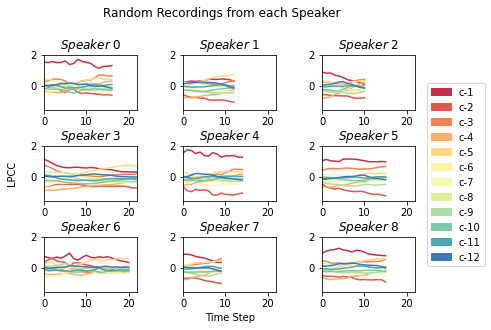

In [2]:
X_train_vowels, y_train_vowels, X_test_vowels, y_test_vowels = get_japanese_vowels()
plot_recordings(X_train_vowels)

Min length: 7 Max length: 26


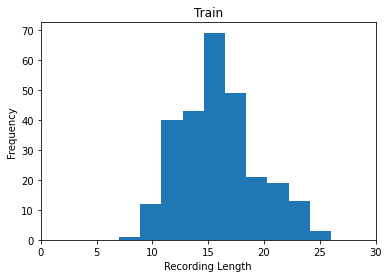

Min length: 7 Max length: 29


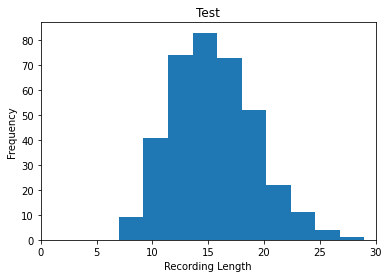

In [3]:
plot_rec_len_freq(X_train_vowels, "Train")
plot_rec_len_freq(X_test_vowels, "Test")

### CNN

In [3]:
X_train_vowels_uni, X_test_vowels_uni = pre_process(X_train_vowels, X_test_vowels, rec_len=30)
input_shape_vowels = (30, 12)
X_train, y_train = tuple(map(np.array, [X_train_vowels_uni, y_train_vowels]))

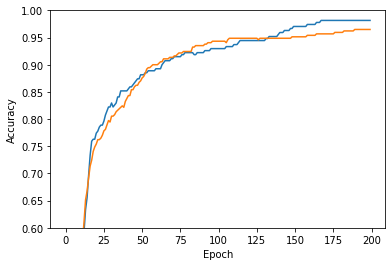

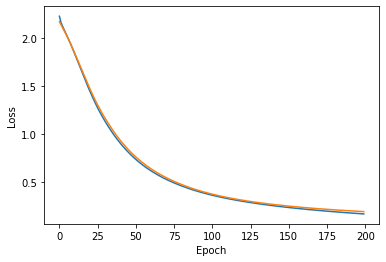

Test loss: 0.18740829825401306 / Test accuracy: 0.9648648500442505


In [5]:
# One model
history, cnn_model = train_cnn(input_shape_vowels, X_train, y_train)
plot_cnn_training(history)
eval_cnn(cnn_model, X_test_vowels_uni, y_test_vowels)

# Cross-validation
cross_val_cnn(input_shape_vowels, X_train, y_train, 5)

### RF

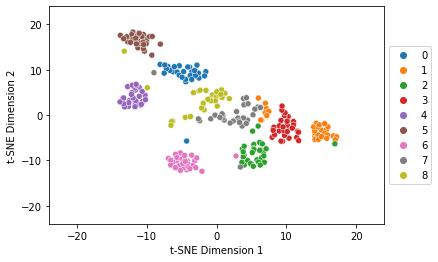

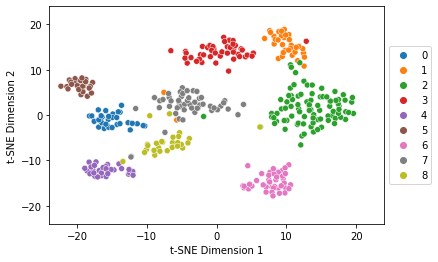

In [4]:
X_feat_train_vowels = extract_features(X_train_vowels_uni)
X_feat_test_vowels = extract_features(X_test_vowels_uni)
X_train, y_train = tuple(map(np.array, [X_feat_train_vowels, y_train_vowels]))
plot_tsne(X_feat_train_vowels, y_train_vowels)
plot_tsne(X_feat_test_vowels, y_test_vowels)

Accuracy 0.9783783783783784
F1-Score 0.9782804927223758


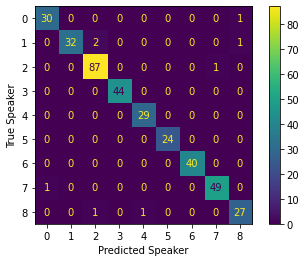

Accuracy 0.9814814814814815
F1-Score 0.9813519813519813
Accuracy 0.9074074074074074
F1-Score 0.9068894068894069
Accuracy 0.9629629629629629
F1-Score 0.9627039627039627
Accuracy 0.9814814814814815
F1-Score 0.9813519813519813
Accuracy 0.9444444444444444
F1-Score 0.9426314426314427
Cross-validation results for 5 folds -> avg. precision: 1.698095238095238


In [5]:
# One model
model = train_rf(X_train, y_train)
cm, acc, f1 = eval_rf(model, X_feat_test_vowels, y_test_vowels)
plot_rf_training(cm)

# Cross-validation
cross_val_rf(X_train, y_train, 5)

---

## Digits dataset

In [6]:
X_digits, y_digits_num, y_digits_speaker = get_spoken_digits()
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X_digits, y_digits_speaker, test_size=0.5, stratify=y_digits_speaker)

Min length: 10 Max length: 152


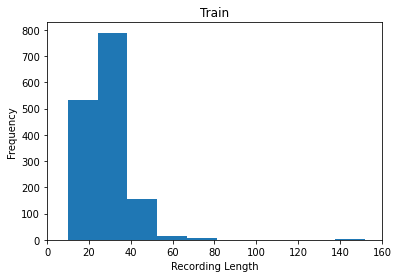

Min length: 9 Max length: 86


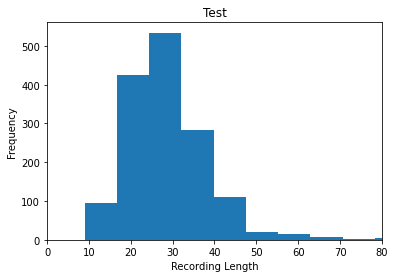

In [7]:
plot_rec_len_freq(X_train_digits, "Train", xmax=160)
plot_rec_len_freq(X_test_digits, "Test", xmax=80)

### CNN

In [9]:
X_train_digits_uni, X_test_digits_uni = pre_process(X_train_digits, X_test_digits, 50)
input_shape_digits = (50, 12)
X_train, y_train = tuple(map(np.array, [X_train_digits_uni, y_train_digits]))

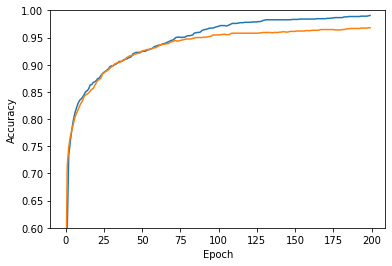

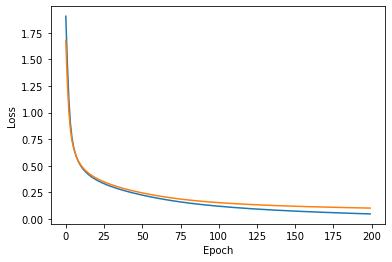

Test loss: 0.10328815877437592 / Test accuracy: 0.9679999947547913


In [11]:
# One model
history_digits, cnn_model_digits = train_cnn(input_shape_digits, X_train, y_train)
plot_cnn_training(history_digits)
eval_cnn(cnn_model_digits, X_test_digits_uni, y_test_digits)

# Cross-validation
cross_val_cnn(input_shape_digits, X_train, y_train, 5)

### RF

Accuracy 0.9726666666666667
F1-Score 0.9725603367384945


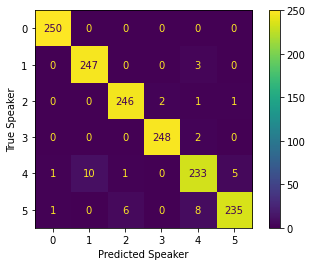

Accuracy 0.9666666666666667
F1-Score 0.9665064102564103
Accuracy 0.98
F1-Score 0.9797092712367212
Accuracy 0.98
F1-Score 0.9799818432808123
Accuracy 0.9833333333333333
F1-Score 0.9832993299329934
Accuracy 0.98
F1-Score 0.9797794117647058
Cross-validation results for 5 folds -> avg. precision: 1.1764214046822743


In [10]:
X_feat_train_digits = extract_features(X_train_digits_uni, n_windows=5)
X_feat_test_digits = extract_features(X_test_digits_uni, n_windows=5)
X_train, y_train = tuple(map(np.array, [X_feat_train_digits, y_train_digits]))

# One model
model = train_rf(X_train, y_train)
cm, acc, f1 = eval_rf(model, X_feat_test_digits, y_test_digits)
plot_rf_training(cm)

# Cross-validation
cross_val_rf(X_train, y_train, 5)